In [19]:
# %config IPCompleter.greedy=True
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
import sklearn

In [20]:
TABLES_FILEPATH = 'tables/'
IMAGES_FILEPATH = 'images/'
RESOURCES_FILEPATH = 'resources/'

In [21]:
train = pd.read_csv(RESOURCES_FILEPATH + 'train_data.csv')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  800 non-null    int64  
 1   Survived     800 non-null    int64  
 2   Pclass       800 non-null    int64  
 3   Sex          800 non-null    object 
 4   Age          637 non-null    float64
 5   SibSp        800 non-null    int64  
 6   Parch        800 non-null    int64  
 7   Ticket       800 non-null    object 
 8   Fare         800 non-null    float64
 9   Cabin        185 non-null    object 
 10  Embarked     799 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 68.9+ KB


In [22]:
# Zapisanie rodzajów zmiennych oraz ilości brakujących danych
lack_of_data_name = 'N/D'
train_isna = pd.DataFrame(train.isna().sum(), columns=[lack_of_data_name])

data_types = ['Numerical Ratio', 'Cathegorical Nominal', 'Cathegorical Ordinal', 'Cathegorical Nominal',
              'Numerical Ratio', 'Numerical Interval', 'Numerical Interval', 'Numerical Interval',
              'Numerical Ratio', 'Text data', 'Cathegorical Nominal']

train_isna['Data types'] = data_types
train_isna.to_csv(TABLES_FILEPATH + 'train_isna.csv')

train_isna

,N/D,Data types
PassengerId,0,Numerical Ratio
Survived,0,Cathegorical Nominal
Pclass,0,Cathegorical Ordinal
Sex,0,Cathegorical Nominal
Age,163,Numerical Ratio
SibSp,0,Numerical Interval
Parch,0,Numerical Interval
Ticket,0,Numerical Interval
Fare,0,Numerical Ratio
Cabin,615,Text data


S    577
C    149
Q     73
Name: Embarked, dtype: int64


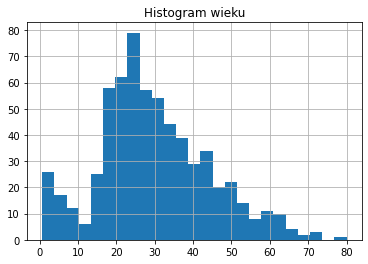

In [23]:
plt.hist(train['Age'], bins=25)
hist_name = 'Histogram wieku'
plt.title(label=hist_name)
plt.grid()
plt.savefig(IMAGES_FILEPATH + hist_name + '.png')
embarked_value_counts = pd.Series.value_counts(train['Embarked'])
print(embarked_value_counts)

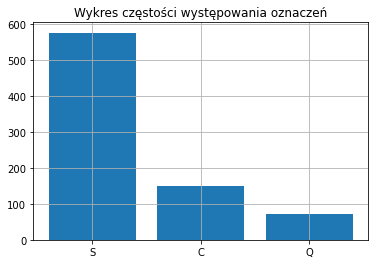

In [24]:
heights = embarked_value_counts
labels = embarked_value_counts.index
plt.bar(labels, heights)
plt.grid()
embarked_hist_name = 'Histogram wejść na statek.png'
plt.title(label='Wykres częstości występowania oznaczeń')
plt.savefig(IMAGES_FILEPATH + embarked_hist_name)
plt.show()

## Typy danych
PassengerId - Numerical, Ratio<br>
Pclass - Cathegorical, Ordinal<br>
Sex - Cathegorical, Nominal<br>
Age - Numerical, Ratio<br>
SibSp - Numerical, Interval<br>
Parch - Numerical, Interval<br>
Ticket - Numerical, Interval<br>
Fare - Numerical, Ratio<br>
Cabin - Text data<br>
Embarked - Cathegorical, Nominal<br>

# Preprocessing
PassengerId - do usunięcia<br>
Pclass - bez zmian<br>
Cabin - do usunięcia<br>
Embarked - wypełnienie najczęściej występującą literą i One-Hot Encoding<br>
Age - rozłożyć uzupełnienie procentowo z uwzględnieniem grup wiekowych, standaryzacja<br>
Sex - One-Hot Encoding<br>
SibSp - bez zmian<br>
Parch - bez zmian<br>
Ticket - do usunięcia<br>
Fare - standaryzacja<br>
Embarked - One-Hot Encoding

In [25]:
# Usunięcie danych uznanych za zbędne
train = train.drop(['Cabin'], axis=1)
train = train.drop(['PassengerId'], axis=1)
train = train.drop(['Ticket'], axis=1)

In [26]:
# Uzupełnienie Embarked najczęstszą wartością
train['Embarked'] = train['Embarked'].fillna(value=train['Embarked'].mode())

#Wartości dobrane ręcznie zakładając 3 grupy wiekowe i podział na (dzieci), (rodzice), (dziadkowie)
age_groups = ((0, 17), (17.001, 50), (50.001, 100))
intervals = []
intervals_counts = []
# wyznaczenie ilości osób z każdej z grup
for group in age_groups:
    interval = train.loc[(train['Age'] >= group[0]) & (train['Age'] <= group[1])]
    intervals.append(interval)
    intervals_counts.append(interval['Age'].count())

# Wyznaczenie procentowego udziału każdej grupy wiekowej
ENTRIES = train.shape[0]
MISSING_AGE = train_isna['N/D']['Age']
percentage_participation = [interval / (ENTRIES - MISSING_AGE) for interval in intervals_counts]

# Wyznaczenie median przypadających na grupy wiekowe oraz ilości osób z danych grup wiekowych, które można uzupełnić zachowując ich procentowy udział
group_age_medians = [interval['Age'].median() for interval in intervals]
limits = [part * MISSING_AGE for part in percentage_participation]
print('Wielkości przedziałów:', intervals_counts)
print('Procentowy udział grup wiekowych w poprawnych danych:', percentage_participation)
print('Mediany grup wiekowych:', group_age_medians)
print('Limity wartości do metody fillna:', limits)



Wielkości przedziałów: [98, 480, 59]
Procentowy udział grup wiekowych w poprawnych danych: [0.15384615384615385, 0.7535321821036107, 0.09262166405023547]
Mediany grup wiekowych: [9.0, 29.0, 58.0]
Limity wartości do metody fillna: [25.076923076923077, 122.82574568288855, 15.097331240188382]


In [27]:
#Dodaję jeden do najczęściej występującej grupy wiekowej ze względu na zmiennoprzecinkowość danych procentowych
limits[1] = int(limits[1] + 1)
for i in range(3):
    train['Age'] = train['Age'].fillna(value=group_age_medians[i], limit=int(limits[i]))

In [28]:
# One hot encoding
train = pd.get_dummies(train, columns=['Sex'], drop_first=True)
train = pd.get_dummies(train, columns=['Embarked'], drop_first=True)
train

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1
...,...,...,...,...,...,...,...,...,...
795,0,2,39.0,0,0,13.0000,1,0,1
796,1,1,49.0,0,0,25.9292,0,0,1
797,1,3,31.0,0,0,8.6833,0,0,1
798,0,3,30.0,0,0,7.2292,1,0,0


In [29]:
# Feature Engineering polegający na utworzeniu zmiennej "Protection" wyrażającej poprawę szansy na dotarcie do szalupy i przeżycie. Wynika ze statusu w rodzinie (dziecko, rodzic, dziadkowie) oraz ilości krewnych. Wzór powoduje np. że jedynacy z rodzicami na statku są mocno premiowani, dzieci bez rodziców otrzymują wartość ujemną. Odwrotnie do tego, rodzice otrzymują 'karę' Protection im więcej dzieci mają. Posiadanie krewnych w tym samym wieku generalnie obniża szansę na przeżycie. Wartość Protection jest od razu znormalizowana.

SIBSP_DIVISION_RATE = 9


def protection_feature(age, sibsp, parch):
    if age > age_groups[0][0] and age <= age_groups[0][1]:
        return (1 / age) * parch - (1 / age) * (sibsp / SIBSP_DIVISION_RATE)
    elif age >= age_groups[1][0] and age <= age_groups[1][1]:
        return (1 / age) * sibsp - (1 / age) * parch
    elif age >= age_groups[2][0] and age <= age_groups[2][1]:
        return (1 / age) * parch - (1 / age) * (sibsp / SIBSP_DIVISION_RATE)


protection = []
for i in range(ENTRIES):
    age, sibSp, parch = train['Age'][i], train['SibSp'][i], train['Parch'][i]
    prot = protection_feature(age, sibSp, parch)
    protection.append(prot)

train['Protection'] = protection
train

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Protection
0,0,3,22.0,1,0,7.2500,1,0,1,0.045455
1,1,1,38.0,1,0,71.2833,0,0,0,0.026316
2,1,3,26.0,0,0,7.9250,0,0,1,0.000000
3,1,1,35.0,1,0,53.1000,0,0,1,0.028571
4,0,3,35.0,0,0,8.0500,1,0,1,0.000000
...,...,...,...,...,...,...,...,...,...,...
795,0,2,39.0,0,0,13.0000,1,0,1,0.000000
796,1,1,49.0,0,0,25.9292,0,0,1,0.000000
797,1,3,31.0,0,0,8.6833,0,0,1,0.000000
798,0,3,30.0,0,0,7.2292,1,0,0,0.000000


In [30]:

y = train['Survived']
survived_count = len([survived for survived in y if survived == 1])
dead_count = len([dead for dead in y if dead == 0])
print(survived_count / (dead_count + survived_count))

# Usunięcie informacji o przetrwaniu ze zbioru argumentów
train = train.drop(['Survived'], axis=1)
X = train.values
y = y.values

# Normalizacja kolumn Age, Fare, Protection, tak aby μ = 0 i σ = 1
sc = StandardScaler()
X_std = sc.fit_transform(X[:, [1, 4, 8]])

0.385


In [31]:
# Podmiana odpowiednich kolumn na znormalizowane
X[:, 1] = X_std[:, 0]
X[:, 4] = X_std[:, 1]
X[:, 8] = X_std[:, 2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

if np.isnan(X_train).any() or np.isnan(X_test).any() or np.isnan(y_train).any() or np.isnan(y_test).any():
    raise Exception('Data has to be complete!')

In [32]:
def show_accuracy(model):
    return accuracy_score(y_test, model.predictions)


def calculate_average_accuracy(model):
    accuracy = []
    for _ in range(500):
        accuracy.append(show_accuracy(model))
    mean = sum(accuracy) / len(accuracy)
    print('Accuracy:', mean)
    return mean


def train_model(model, grid_parameters):
    grid = GridSearchCV(model, grid_parameters, n_jobs=-1, verbose=10)
    grid.fit(X_train, y_train)
    print(f'Best score: {grid.best_score_}')
    print(f'Best parameters: {grid.best_params_}')
    return grid.best_estimator_


def validate_model(model):
    name = str(model).split(sep='(', maxsplit=1)[0]

    # walidacja krzyżowa
    validation = cross_val_score(model, X, y, cv=10)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    score = round(accuracy_score(y_test, pred), ndigits=4)
    print(f'{name} \n Accuracy: {score}')
    print(validation.mean(), validation.std() * 2)
    plot_confusion_matrix(model, X_test, y_test)
    plt.title(label=(name + f' (score: {score})'))
    plt.savefig(IMAGES_FILEPATH + name + '.png')
    plt.show()


# scores = pd.read_csv('score1.csv')
columns = ['KNN', 'TREE', 'LR', 'BAYES', 'SVC']


def find_best_knn():
    n_neighbors = np.arange(3, 10, 1)
    weights = ['uniform', 'distance']
    algorithm = ['ball_tree']
    leaf_size = np.arange(20, 40, 1)
    # metric = [DistanceMetric.get_metric('haversine')]
    metric = sklearn.neighbors.VALID_METRICS['ball_tree']
    # metric.remove('haversine')
    # metric.remove('mahalanobis')
    # metric.remove('seuclidean')
    # metric.remove('wminkowski')
    # metric.remove('pyfunc')
    n_jobs = [-1]

    grid_parameters = {
        'n_neighbors': n_neighbors,
        'weights': weights,
        'algorithm': algorithm,
        'leaf_size': leaf_size,
        'metric': metric,
        'n_jobs': n_jobs
    }

    knn = KNeighborsClassifier()
    best_knn = train_model(knn, grid_parameters)

    return best_knn


def find_best_tree():
    criterion = ['gini', 'entropy']
    splitter = ['best', 'random']
    min_samples_split = np.arange(2, 5, 1)
    min_samples_leaf = np.arange(1, 5, 1)
    max_features = ['sqrt', 'log2']


def find_best_svc():
    C = [0.5, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    kernel = ['linear', 'rbf']
    #degree = np.arange(2, 10, 1)
    gamma = ['scale', 'auto', 0.5, 2, 4, 8]
    #coef0 = np.arange(0, 2, 0.2)
    class_weight = ['balanced', None]
    grid_parameters = {
        'C': C,
        'kernel': kernel,
        #'degree': degree,
        'gamma': gamma,
        #'coef0': coef0,
        'class_weight': class_weight
    }
    svc = SVC()
    best_svc = train_model(svc, grid_parameters)
    return best_svc


# Całiem słaby algorytm gdyż zakłada wzajemną niezależność zmiennych, co w przypadku ofiar Titanica jest kompletnie bez sensu
def find_best_gaussianNB():
    priors = ['']
    var_smoothing = [1e-7, 5e-7, 1e-8, 5e-8, 1e-9, 5e-9, 1e-10]
    grid_parameters = {
        'var_smoothing': var_smoothing
    }
    gaussianNB = GaussianNB()
    best_gaussianNB = train_model(gaussianNB, grid_parameters)
    return best_gaussianNB


def find_best_logistic_regression():
    penalty = ['l2']
    dual = [False]
    tol = [1e-1, 5e-1, 1e-2, 5e-2, 1e-3, 5e-3, 1e-4, 5e-4, 1e-5, 5e-5]
    C = [0.1, 0.2, 0.3, 0.4, 0.5]
    solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    grid_parameters = {
        'penalty': penalty,
        'dual': dual,
        'tol': tol,
        'C': C,
        'solver': solver
    }
    lr = LogisticRegression(max_iter=1000)
    best_lr = train_model(lr, grid_parameters)
    return best_lr

In [33]:
# Funkcje do znalezienia potencjalnie najlepszego modelu
# UWAGA: Komputer może mocno zwolnić po uruchomieniu wszystkich naraz
# best_knn = find_best_knn()
# best_svc = find_best_svc()
# best_lr = find_best_logistic_regression()
# best_gnb = find_best_gaussianNB()

KNeighborsClassifier 
 Accuracy: 0.8125
0.7949999999999999 0.09096702699330123


/home/jakubszwedowicz/miniconda3/envs/Projekt/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


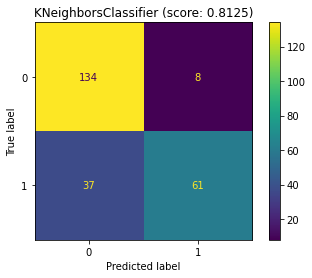

SVC 
 Accuracy: 0.8458
0.82125 0.07749999999999997


/home/jakubszwedowicz/miniconda3/envs/Projekt/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


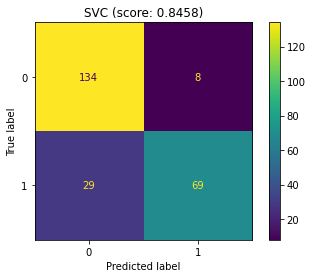

LogisticRegression 
 Accuracy: 0.85
0.80625 0.0634921254960015


/home/jakubszwedowicz/miniconda3/envs/Projekt/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


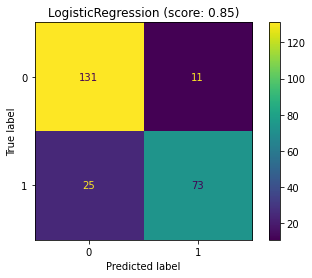

GaussianNB 
 Accuracy: 0.7958
0.7925 0.07599342076785333


/home/jakubszwedowicz/miniconda3/envs/Projekt/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


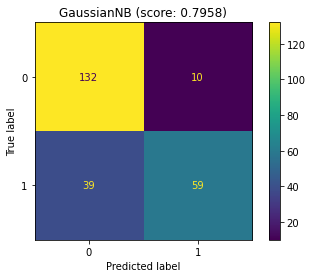

In [34]:
best_knn = KNeighborsClassifier(algorithm='ball_tree', leaf_size=28, metric='hamming', n_jobs=-1, n_neighbors=9,
                                weights='uniform')
validate_model(best_knn)

best_svc = SVC(C=4, gamma='auto')
validate_model(best_svc)

best_lr = LogisticRegression(C=0.3, tol=0.001)
validate_model(best_lr)

best_gnb = GaussianNB(var_smoothing=1e-7)
validate_model(best_gnb)